<center><img src="https://gsb.skku.edu/_res/en/img/common/logo_eng.png" align="center"></img></center>

<center><font size="6">Data Driven Asset Management Part 2.1</font></center>
<p>
<center><font size="3">Trading Strategy with Value Stocks by Yanbo Wang</font></center>

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please put `Data-Driven Asset Management - Part 2` folder under your Google Drive root folder.

In [4]:
folder='/content/drive/MyDrive/AIMBA-8-2/'

# Data Preparation

## Import Value Stock Descriptors (aka Signals)

We obtained signal dataset from **Open Source Asset Pricing Project** at `https://www.openassetpricing.com`.

Financial Ratios

<table>
    <tr>
        <th>Acronym</th>
        <th>Long Description</th>
        <th>Detailed Definition</th>
    </tr>
    <tr>
        <td>BM</td>
        <td>Book to market, original (Stattman 1980)</td>
        <td>Log of tangible book equity (ceqt) over market equity matched at FYE</td>
    </tr>
    <tr>
        <td>cfp</td>
        <td>Operating Cash flows to price</td>
        <td>Operating cash-flow (oancf) divided by market value of equity. If operating cash-flow is missing, replace by difference between net income (ib) and level of accruals, where the latter is the annual change in current assets (act) minus the annual change in cash and short-term investments (che), minus the annual change in current liabilities (lct) plus the annual change in debt in current liabilities (dlc) plus the annual change in payable income taxes (txp) plus depreciation (dp).</td>
    </tr>
    <tr>
        <td>EP</td>
        <td>Earnings-to-Price Ratio</td>
        <td>ib / lag(market value of equity, 6 months). NYSE stocks only. Exclude if EP < 0. Lag simulates the Dec 31 market equity user</td>
    </tr>
</table>

</body>
</html>


In [5]:
bm=pd.read_csv(folder+'BM.csv')
print(bm.shape[0])
bm.head()

353099


,permno,yyyymm,BM
0,10000,198704.0,-2.895161
1,10000,198705.0,-2.895161
2,10001,198612.0,-0.104958
3,10001,198701.0,-0.104958
4,10001,198702.0,-0.104958


In [6]:
cfp=pd.read_csv(folder+'cfp.csv')
print(cfp.shape[0])
cfp.head()

395302


,permno,yyyymm,cfp
0,10001,198712,0.009094
1,10001,198801,0.008548
2,10001,198802,0.007915
3,10001,198803,0.008723
4,10001,198804,0.008464


In [7]:
ep=pd.read_csv(folder+'EP.csv')
print(ep.shape[0])
ep.head()

398841


,permno,yyyymm,EP
0,10001,198612.0,0.110888
1,10001,198701.0,0.112031
2,10001,198702.0,0.104490
3,10001,198703.0,0.105894
4,10001,198704.0,0.101898


In [8]:
v=bm.merge(cfp, on=['permno', 'yyyymm'], how='outer').merge(ep, on=['permno', 'yyyymm'], how='outer')
v.columns=[x.lower() for x in v.columns]
print(v.shape[0])
v.head()

547093


,permno,yyyymm,bm,cfp,ep
0,10000,198704.0,-2.895161,NaN,NaN
1,10000,198705.0,-2.895161,NaN,NaN
2,10001,198612.0,-0.104958,NaN,0.110888
3,10001,198701.0,-0.104958,NaN,0.112031
4,10001,198702.0,-0.104958,NaN,0.104490


## Import Stock Data

We obtained signal dataset from **WRDS** at `/WRDS/CRSP/MSF`.

In [11]:
ret=pd.read_pickle(folder+'msf.pkl')
ret=ret.sort_values(['permno', 'date'])
ret['market_cap']=ret.apply(lambda x: abs(x['shrout']*x['prc']), axis=1)
ret['market_cap_l']=ret.groupby('permno')['market_cap'].shift(1)
ret['pdate']=ret.groupby('permno')['date'].shift(1)
ret['yyyymm']=ret['pdate'].apply(lambda x: x.year*100+x.month)
ret=ret[['permno', 'date', 'ret', 'yyyymm', 'market_cap_l']]
print(ret.shape[0])
ret.head()

2053554


,permno,date,ret,yyyymm,market_cap_l
188,10001.0,2000-01-31,-0.044118,NaN,NaN
189,10001.0,2000-02-29,0.015385,200001.0,19906.25
190,10001.0,2000-03-31,-0.015758,200002.0,20212.50
191,10001.0,2000-04-28,0.011719,200003.0,19712.00
192,10001.0,2000-05-31,-0.023166,200004.0,19943.00


## Merge Stock Data and Value Stock Descriptors

In [12]:
d=ret.merge(v, on=['permno', 'yyyymm'])
print(d.shape[0])
d=d.drop(['yyyymm'], axis=1)
d.to_pickle(folder+'value_stocks.pkl')
d.head()

218815


,permno,date,ret,market_cap_l,bm,cfp,ep
0,10001.0,2000-02-29,0.015385,19906.25,-0.445696,0.315177,0.073504
1,10001.0,2000-03-31,-0.015758,20212.50,-0.445696,0.310402,0.074029
2,10001.0,2000-04-28,0.011719,19712.00,-0.445696,0.318283,0.080969
3,10001.0,2000-05-31,-0.023166,19943.00,-0.445696,0.314597,0.074562
4,10001.0,2000-06-30,0.027668,19481.00,-0.445696,0.322057,0.074831


# Long-Short Portfolio Strategy on Value Stocks

## Calculate Value Stock Signal (Descriptor)

In [13]:
d=pd.read_pickle(folder+'value_stocks.pkl')
d.head()

,permno,date,ret,market_cap_l,bm,cfp,ep
0,10001.0,2000-02-29,0.015385,19906.25,-0.445696,0.315177,0.073504
1,10001.0,2000-03-31,-0.015758,20212.50,-0.445696,0.310402,0.074029
2,10001.0,2000-04-28,0.011719,19712.00,-0.445696,0.318283,0.080969
3,10001.0,2000-05-31,-0.023166,19943.00,-0.445696,0.314597,0.074562
4,10001.0,2000-06-30,0.027668,19481.00,-0.445696,0.322057,0.074831


In [14]:
import numpy as np

def z_score(df):
    # Calculate the mean and standard deviation of the descriptor values
    mean = df.mean()
    std_dev = df.std()
    df=(df-mean)/std_dev

    # Define a threshold for outliers (e.g., three standard deviations from the mean)
    threshold = 3

    # Apply winsorization to cap values within the threshold
    return np.clip(df, -3, 3)

In [15]:
import numpy as np

def winsor(df):
    # Calculate the mean and standard deviation of the descriptor values
    mean = df.mean()
    std_dev = df.std()
    #df=(df-mean)/std_dev

    # Define a threshold for outliers (e.g., three standard deviations from the mean)
    threshold = 3

    # Apply winsorization to cap values within the threshold
    return np.clip(df, mean-threshold*std_dev, mean+threshold*std_dev)

In [16]:
d[['ret', 'bm', 'cfp', 'ep']].describe()

,ret,bm,cfp,ep
count,217662.000000,140284.000000,202073.000000,130567.000000
mean,0.008574,-1.097278,0.020528,0.076425
std,0.211047,1.177378,1.104062,0.238450
min,-0.983876,-9.617375,-54.515289,0.000000
25%,-0.073791,-1.755998,-0.031724,0.030522
50%,0.000859,-0.918140,0.047958,0.053210
75%,0.071695,-0.316103,0.116422,0.081413
max,19.883589,3.713971,184.550050,22.809662


In [17]:
for x in ['bm', 'cfp', 'ep']:
    d[x]=d.groupby('date')[x].transform(z_score)
d['ret']=d.groupby('date')['ret'].transform(winsor)
d[['ret', 'bm', 'cfp', 'ep']].describe()

,ret,bm,cfp,ep
count,217662.000000,140284.000000,202073.000000,130567.000000
mean,0.004528,0.008546,-0.000124,-0.040643
std,0.165586,0.963716,0.623687,0.620627
min,-0.892433,-3.000000,-3.000000,-1.913160
25%,-0.073791,-0.533841,-0.130528,-0.330787
50%,0.000859,0.139649,0.027467,-0.126396
75%,0.071695,0.670986,0.192364,0.066539
max,1.895019,3.000000,3.000000,3.000000


In [18]:
print(d.shape[0])
d=d.dropna()
print(d.shape[0])
d['value_score']=(d['bm']+d['cfp']+d['ep'])/3
d.head()

218815
79075


<ipython-input-18-b3d95bb3d6c0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['value_score']=(d['bm']+d['cfp']+d['ep'])/3


,permno,date,ret,market_cap_l,bm,cfp,ep,value_score
0,10001.0,2000-02-29,0.015385,19906.25,0.348994,0.600105,0.004072,0.317724
1,10001.0,2000-03-31,-0.015758,20212.50,0.354177,0.625425,-0.017727,0.320625
2,10001.0,2000-04-28,0.011719,19712.00,0.365708,0.568345,0.025624,0.319893
3,10001.0,2000-05-31,-0.023166,19943.00,0.365051,0.469370,-0.068807,0.255205
4,10001.0,2000-06-30,0.027668,19481.00,0.372362,0.451574,-0.054672,0.256421


## Decide Long (Buy) or Short (Sell)

In [19]:
def decide_long_short(df):

    # Define a threshold to select top and bottom percentile of value scores
    threshold = 0.7  # For example, select top 30% as long and bottom 30% as short

    # Calculate the cutoff values for long and short portfolios
    long_cutoff = df.quantile(threshold)
    short_cutoff = df.quantile(1-threshold)

    # Create a long portfolio with stocks having high value scores
    # Create a short portfolio with stocks having low value scores
    def long_or_short(x):
        if x>long_cutoff:
            return 'Buy'
        elif x<short_cutoff:
            return 'Sell'
        else:
            return 'Exclude'

    return df.apply(long_or_short)

In [32]:
d['trade_decision']=d.groupby('date')['value_score'].transform(decide_long_short)
d.head()

,permno,date,ret,market_cap_l,bm,cfp,ep,value_score,final_value_score,weight,weight% USA Value,weight% USA,w% x return USA Value,w% x return USA,trade_decision
0,10001.0,2000-02-29,0.015385,19906.25,0.348994,0.600105,0.004072,0.317724,1.317724,26230.934603,0.000014,0.000006,2.144808e-07,9.653273e-08,Buy
1,10001.0,2000-03-31,-0.015758,20212.50,0.354177,0.625425,-0.017727,0.320625,1.320625,26693.136219,0.000014,0.000006,-2.213115e-07,-9.912679e-08,Buy
2,10001.0,2000-04-28,0.011719,19712.00,0.365708,0.568345,0.025624,0.319893,1.319893,26017.721240,0.000013,0.000006,1.474080e-07,6.486779e-08,Buy
3,10001.0,2000-05-31,-0.023166,19943.00,0.365051,0.469370,-0.068807,0.255205,1.255205,25032.544117,0.000013,0.000006,-2.954596e-07,-1.381835e-07,Buy
4,10001.0,2000-06-30,0.027668,19481.00,0.372362,0.451574,-0.054672,0.256421,1.256421,24476.343230,0.000013,0.000006,3.599258e-07,1.700691e-07,Buy


In [21]:
d.groupby('trade_decision')['value_score'].describe()

,count,mean,std,min,25%,50%,75%,max
trade_decision,,,,,,,,
Buy,23774.0,0.554807,0.366389,0.038063,0.320415,0.436756,0.659108,3.000000
Exclude,31512.0,0.044350,0.149961,-0.425495,-0.057166,0.061593,0.158727,0.437941
Sell,23789.0,-0.481861,0.261940,-1.668959,-0.641394,-0.432604,-0.277102,-0.033011


## Construct Long-Short Trading Portfolio

In [22]:
import numpy as np

In [34]:
p=d.groupby(['date', 'trade_decision'])['ret'].mean().unstack()
# p=d.groupby(['date', 'trade_decision'])['ret'].mean()

p=p.sort_index()
p.head()

trade_decision,Buy,Exclude,Sell
date,,,
2000-02-29,0.044906,0.050809,0.125319
2000-03-31,0.019832,0.045138,0.011068
2000-04-28,-0.058430,-0.019899,-0.059423
2000-05-31,-0.011776,-0.019444,-0.035868
2000-06-30,0.026309,0.038939,0.034015


<ipython-input-24-922a7e2dd1b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['Cumulative Trading Return (Long)']=(1+p['Buy']).cumprod()
<ipython-input-24-922a7e2dd1b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['Cumulative Trading Return (Short)']=(1+p['Sell']).cumprod()


<Axes: xlabel='date'>

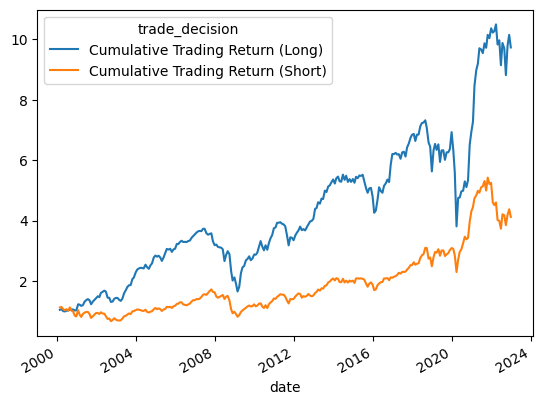

In [24]:
p=p.loc['2000':'2024']
p['Cumulative Trading Return (Long)']=(1+p['Buy']).cumprod()
p['Cumulative Trading Return (Short)']=(1+p['Sell']).cumprod()
p[['Cumulative Trading Return (Long)', 'Cumulative Trading Return (Short)']].plot()

<Axes: xlabel='date'>

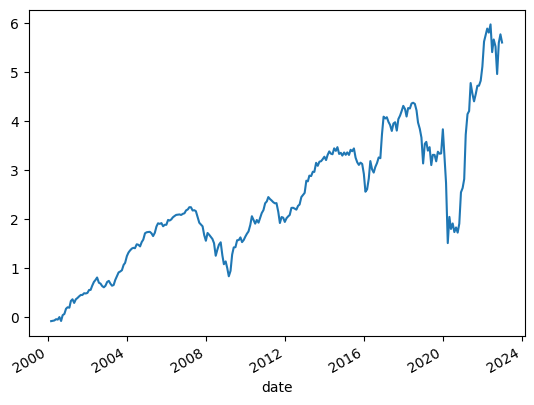

In [25]:
p['Cumulative Trading Return (Long Short)']=p['Cumulative Trading Return (Long)']-p['Cumulative Trading Return (Short)']
p['Cumulative Trading Return (Long Short)'].plot()

# MSCI Index Based on Value Stocks

## Calculate Score by MSCI Enhanced Value Index

In [26]:
d=d.drop('trade_decision', axis=1)
d.head()

,permno,date,ret,market_cap_l,bm,cfp,ep,value_score
0,10001.0,2000-02-29,0.015385,19906.25,0.348994,0.600105,0.004072,0.317724
1,10001.0,2000-03-31,-0.015758,20212.50,0.354177,0.625425,-0.017727,0.320625
2,10001.0,2000-04-28,0.011719,19712.00,0.365708,0.568345,0.025624,0.319893
3,10001.0,2000-05-31,-0.023166,19943.00,0.365051,0.469370,-0.068807,0.255205
4,10001.0,2000-06-30,0.027668,19481.00,0.372362,0.451574,-0.054672,0.256421


In [27]:
d['final_value_score']=d['value_score'].apply(lambda x: 1+x if x>=0 else 1/(1-x))
d['final_value_score'].describe()

count    79075.000000
mean         1.095275
std          0.405590
min          0.374678
25%          0.795921
50%          1.061445
75%          1.298978
max          4.000000
Name: final_value_score, dtype: float64

## Weight Scheme

In [28]:
d['weight']=d['market_cap_l']*d['final_value_score']
d['weight% USA Value']=d['weight']/d.groupby('date')['weight'].transform('sum')
d['weight% USA']=d['market_cap_l']/d.groupby('date')['market_cap_l'].transform('sum')
d.head()

,permno,date,ret,market_cap_l,bm,cfp,ep,value_score,final_value_score,weight,weight% USA Value,weight% USA
0,10001.0,2000-02-29,0.015385,19906.25,0.348994,0.600105,0.004072,0.317724,1.317724,26230.934603,0.000014,0.000006
1,10001.0,2000-03-31,-0.015758,20212.50,0.354177,0.625425,-0.017727,0.320625,1.320625,26693.136219,0.000014,0.000006
2,10001.0,2000-04-28,0.011719,19712.00,0.365708,0.568345,0.025624,0.319893,1.319893,26017.721240,0.000013,0.000006
3,10001.0,2000-05-31,-0.023166,19943.00,0.365051,0.469370,-0.068807,0.255205,1.255205,25032.544117,0.000013,0.000006
4,10001.0,2000-06-30,0.027668,19481.00,0.372362,0.451574,-0.054672,0.256421,1.256421,24476.343230,0.000013,0.000006


In [29]:
d['w% x return USA Value']=d['ret']*d['weight% USA Value']
d['w% x return USA']=d['ret']*d['weight% USA']
d.head()

,permno,date,ret,market_cap_l,bm,cfp,ep,value_score,final_value_score,weight,weight% USA Value,weight% USA,w% x return USA Value,w% x return USA
0,10001.0,2000-02-29,0.015385,19906.25,0.348994,0.600105,0.004072,0.317724,1.317724,26230.934603,0.000014,0.000006,2.144808e-07,9.653273e-08
1,10001.0,2000-03-31,-0.015758,20212.50,0.354177,0.625425,-0.017727,0.320625,1.320625,26693.136219,0.000014,0.000006,-2.213115e-07,-9.912679e-08
2,10001.0,2000-04-28,0.011719,19712.00,0.365708,0.568345,0.025624,0.319893,1.319893,26017.721240,0.000013,0.000006,1.474080e-07,6.486779e-08
3,10001.0,2000-05-31,-0.023166,19943.00,0.365051,0.469370,-0.068807,0.255205,1.255205,25032.544117,0.000013,0.000006,-2.954596e-07,-1.381835e-07
4,10001.0,2000-06-30,0.027668,19481.00,0.372362,0.451574,-0.054672,0.256421,1.256421,24476.343230,0.000013,0.000006,3.599258e-07,1.700691e-07


## MSCI USA Enhanced Value Index (USD)

In [30]:
p=d.loc['2000':].groupby('date')[['w% x return USA Value', 'w% x return USA']].sum()
p.columns=['MSCI USA Enhanced Value Monthly', 'MSCI USA Monthly']
p=p.sort_index()
p.head()

,MSCI USA Enhanced Value Monthly,MSCI USA Monthly
date,,
2000-02-29,-0.005700,-0.003328
2000-03-31,0.056028,0.058271
2000-04-28,-0.002176,-0.004987
2000-05-31,-0.005797,-0.006136
2000-06-30,-0.005663,0.002189


<Axes: xlabel='date'>

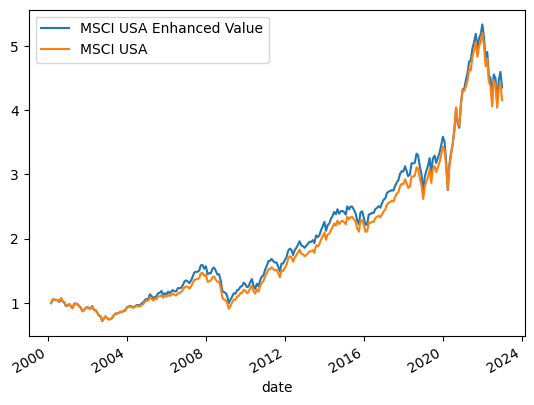

In [31]:
p['MSCI USA Enhanced Value']=(1+p['MSCI USA Enhanced Value Monthly']).cumprod()
p['MSCI USA']=(1+p['MSCI USA Monthly']).cumprod()
p[['MSCI USA Enhanced Value', 'MSCI USA']].plot()